In [2]:
import pandas as pd
import numpy as np
import os
import shap
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# SHAP values for explaining Trees

As we discussed in the lecture Shapley values are in many ways the most rigorous explanation mechanism for machine learning methods. They are properly theoretically rooted in Game Theory. However, we also noted that Shapley values become extremely expensive to calculate as the number of features increases - exponentially increasing.

However, a recent paper [From local explanations to global understanding with explainable AI for trees](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D) developed an efficient algorithm for calculating Shapley values for decision trees in polynomial time, making them far more tractable.

The paper also provides a tool `TreeExplainer` which includes efficient *C++* implementations of the algorithm for trees obtained from a number of popular packages:  *XGBoost*, *LightGBM*, *CatBoost*, *scikit-learn* and *pyspark*.

In this practical exercise we use the `TreeExplainer` to look at the gradient boosted decision tree that we derived in the earlier practical.

## Start by loading the data

In [5]:
oxides = pd.read_pickle('../data/training_data.pickle')
model = pickle.load(open('../models/gb_tree_best.pkl', 'rb'))
cols = [a for a in list(oxides.columns) if a not in ['gllbsc_gap']]
X = oxides[cols]

## Now initiate `TreeExplainer`

Note that `TreeExplainer` uses JavaScript to make some of the nice interactive plots, so sometimes this does not run well in Jupyter Lab. In Jupyter Notebooks, however, it seems to be just fine.

In [5]:
shap.initjs()
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


## Calculate the SHAP values

In [6]:
shap_values = explainer.shap_values(X)

### Exercise 1: Look at individual cases

We can use the `force_plot` function of `TreeExplainer` to plot the Shapley values for a given example from the training or test set.

You just tell the function which instance you want to look at - by index number. Let's look at number 16 first, for example.

The resultant plot tells us which features contributed to moving this example *above* the mean of the training set (red) and which contributed to moving it *below* the mean (blue). For example 16 the HOMO energy contributed to a higher than average gap, the range of NdValence electrons contributed to pulling the gap down.

In [22]:
ind = 16
shap.force_plot(explainer.expected_value, shap_values[ind,:], 
                X.iloc[ind,:])

### Stacking up local explanations

You can plot a range of these explanations by simply using `force_plot` but giving a range rather than single index. This produces an interactive plot which you can order in different ways. Let's take a look for the first 100 examples from our data `X`.

This plot produces a lot of information. By playing around with the orderings different relationships can be interrogated. For example, we can set the x-axis to be `sample order by output value` so that the examples with largest predicted bandgap are on the left.  Choose `MagpieData avg_dev Electronegativity effects` as the y-axis. You can see that generally this feature contributes a small amount to the gap being predicted above average, except for very low end gaps where it contributes to pulling the predicted gap down. 

Now try `avg d valence electrons` on the y-axis. Notice that for the materials with the highest gaps this is a very important contributor and tends to be less important as gaps decrease.

In [24]:
lim = 100
shap.force_plot(explainer.expected_value[:lim], shap_values[:lim], X.iloc[:lim])

### Looking at feature effects across the dataset

We can use the `summary_plot` function to get summaries of how the Shapley values contribute to predictions across our dataset. 

In the plot below the features are ordered from the top in order of overall contribution, the scatter points are then coloured according to the (normalised) magnitude of that feature. 

So we can see HOMO energy is most important for predicting band gap and we can also see that if HOMO is high (large) then it contributes negatively to the band gap - makes sense. In fact there are quite clear splits for a number of features, suggesting well defined contributions to the overall predicted bandgap.

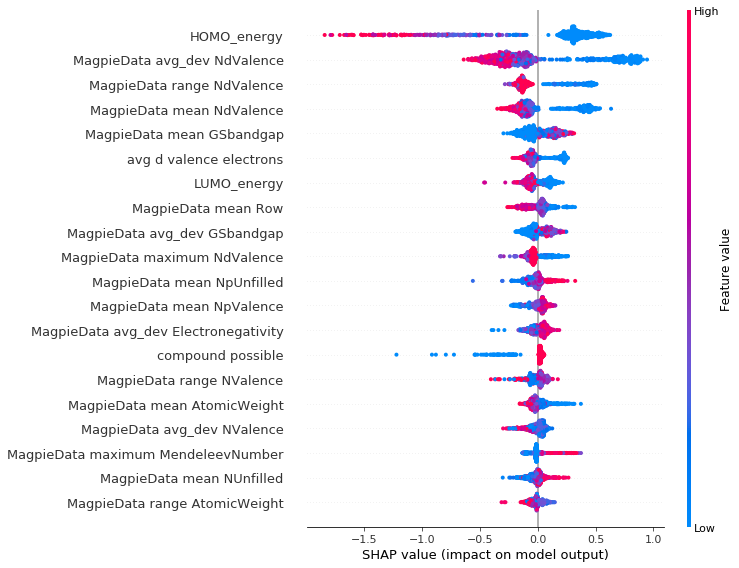

In [18]:
shap.summary_plot(shap_values, X)

### How a feature's impact depends on its value

We can use `dependence_plots` to look at how the value of a given feature impacts the Shapley value of that feature for the model prediction. Below we look at HOMO and LUMO energy dependence plots.

For HOMO it is clear that more negative HOMO energies contribute positively to the bandgap predictions, while less negative HOMO contributes more negatively to predicted gaps. For LUMO energies the trend is not as clear at all.

We can set an interaction feature index too. So that in the LUMO example we have specified that the scatter points should be coloured by the normalised magnitude of the HOMO energy. Notice how, for a few LUMO energies in the middle of the rage the LUMO has a larger negative SHAP value, also notice that for all of these the HOMO value is very low. Suggesting that if the HOMO energy is deep, then the LUMO energy can play a role in reducing the band gap, but this is not observed when the HOMO is shallow. Interestingly also, deep HOMO and deep LUMO do not seem to occur together, i.e. all points on the left of the LUMO plot are blue. 

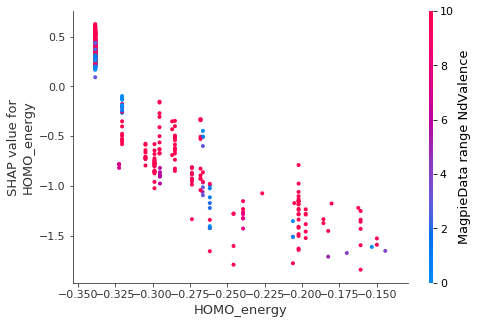

In [16]:
shap.dependence_plot("HOMO_energy", shap_values, X)

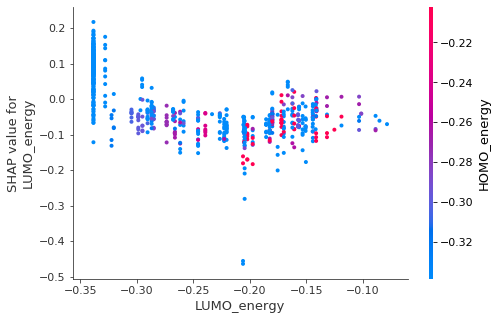

In [25]:
shap.dependence_plot("LUMO_energy", shap_values, X, interaction_index="HOMO_energy")